In [1]:
import numpy as np
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']= (12, 12)
mpl.rcParams['axes.grid'] = False

import PIL.Image
import time
import functools

In [8]:
# define helpful functions

# function to convert a tensor to an image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# function to load an image and limit its maximum dimension to 512 pixels
def load_img(path_to_img):
    max_dim = 512
    # read the image
    img = tf.io.read_file(path_to_img)
    # convert image to tensor
    img = tf.io.decode_image(img, channels=3)
    # convert the image tensors to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.shape(img)[:-1]
    # cast shape into type float32
    shape = tf.cast(shape, tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# create a function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

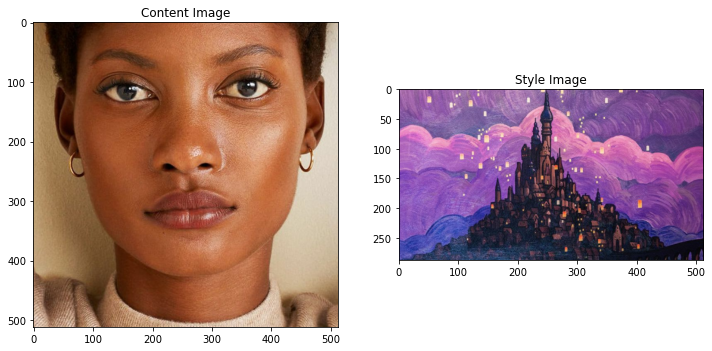

In [11]:
content_path = './data/woman.jpg'
style_path = './data/art2.jpg'


content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Define content and style representations

In [13]:
# ### LOAD A VGG AND TEST ON IMAGE TO ENSURE IT IS USED CORRECTLY
# x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
# x = tf.image.resize(x, (224, 224))
# vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# prediction_probabilities = vgg(x)
# prediction_probabilities.shape

In [14]:
# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [15]:
### load a vgg without the classification head and list the layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 522s 7us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [17]:
### You can easily use keras to extract intermediate layers using tf.keras.applications

def vgg_layers(layer_names):
    """
    Creates a vgg model that returns a list of intermediate output values
    """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # freeze the vgg layers
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [18]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

block1_conv1
    shape:  (1, 288, 512, 64)
    min:  0.0
    max:  791.9617
    mean:  28.540422

block2_conv1
    shape:  (1, 144, 256, 128)
    min:  0.0
    max:  3310.7896
    mean:  145.22737

block3_conv1
    shape:  (1, 72, 128, 256)
    min:  0.0
    max:  7845.3794
    mean:  139.25752

block4_conv1
    shape:  (1, 36, 64, 512)
    min:  0.0
    max:  17785.494
    mean:  564.83673

block5_conv1
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  2951.6711
    mean:  47.77836



Content can be represented by values of intermediate feature maps while style can be represented by correlations using a gram matrix (feature map * feature map transpose)

In [19]:
### CALCULATE STYLE
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

In [24]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expects float input in [0, 1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [25]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()
    
print("Contents:")
for name, output in sorted(results['content'].items()):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

Styles:
block1_conv1
  shape:  (1, 64, 64)
  min:  0.0013541912
  max:  14888.374
  mean:  381.74606

block2_conv1
  shape:  (1, 128, 128)
  min:  0.0
  max:  55811.7
  mean:  8321.803

block3_conv1
  shape:  (1, 256, 256)
  min:  0.0
  max:  213999.94
  mean:  6807.917

block4_conv1
  shape:  (1, 512, 512)
  min:  0.0
  max:  1849238.9
  mean:  139385.53

block5_conv1
  shape:  (1, 512, 512)
  min:  0.0
  max:  102732.0
  mean:  1254.1931

Contents:
block5_conv2
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  1249.3761
  mean:  13.42516



With the style and content extractor in place, I can now implement the style transfer algorithm. This will be done by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set the style and content target values

In [26]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [27]:
"""
Define a tf.Variable to optimize. For speed, we initialize the variable with the content image
so that they'll both have the same shape
"""

image = tf.Variable(content_image)

In [28]:
# define a clipping function to keep pixel values between 0 and 1

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [29]:
# define an optimizer. The paper recommends lbgfs but I prefer adam

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# to optimize the function, we use a weighted combination of the 2 losses we defined above
style_weight = 1e-2
content_weight = 1e4

In [30]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [31]:
# tf.GradientTape to update the image
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

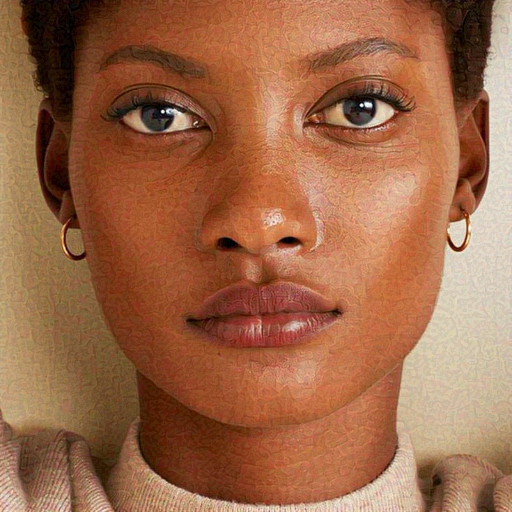

In [32]:
# run a few steps for testing purpose
train_step(image)
tensor_to_image(image)

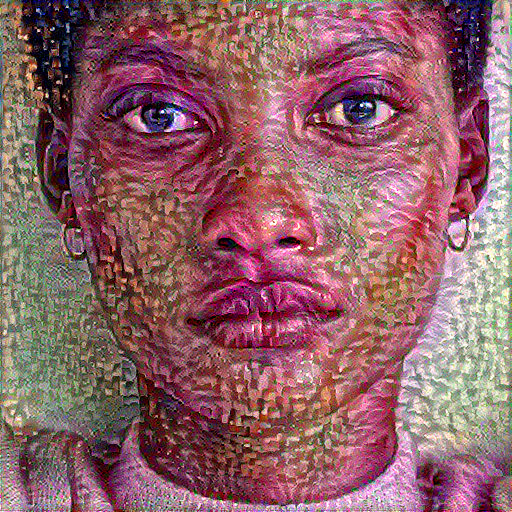

Train step: 100
Total time: 1230.5


In [33]:
# since it works, let's perform a longer optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 5

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train step: {step}")
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

The network needs to be trained for a longer epoch in order to achieve the desired look and feel


### Total Variation Loss
One of the disadvantages of the basic method is that it produces a lot of high frequency artifacts. We are going to use a type of regularization called total variation loss to reduce these high frequency artifacts

Note: The total variation loss is basically an edge detector. You can get similar outputs using the sobel edge detector

`plt.figure(figsize=(14,10))`

`sobel = tf.image.sobel_edges(content_image)`

`plt.subplot(1,2,1)`

`imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")`

`plt.subplot(1,2,2)`

`imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")`

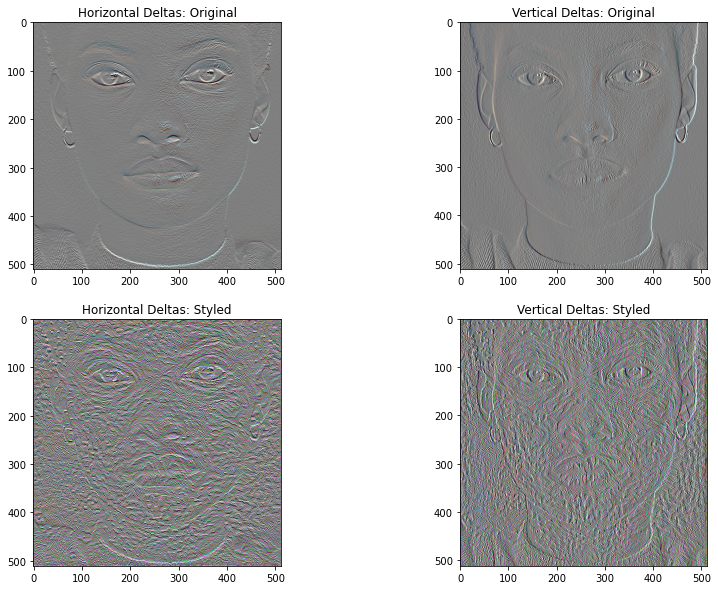

In [34]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [35]:
# regularization loss associated with total variation loss is regression error

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

151076.78

In [36]:
# Note: There is already an implementation in tensorflow
tf.image.total_variation(image).numpy()

array([151076.78], dtype=float32)

In [37]:
# choose a weight for total variation loss and include it in the train step function

total_variation_weight = 30


@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [38]:
# reinitialize the variable
image = tf.Variable(content_image)

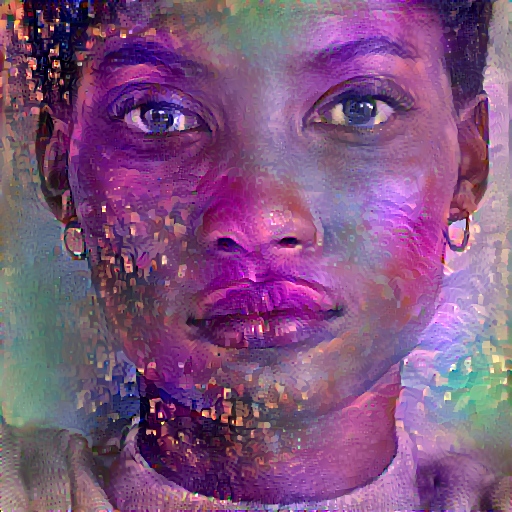

Train step: 900
.................................................................................................

In [ ]:
# rerun the optimization
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train step: {step}")
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
# save the result
filename = 'transformed_image.png'
tensor_to_image(image).save(f"./output/{filename}")